In [6]:
import pandas as pd
import numpy as np
import pdb, argparse
import os, pdb, math, itertools
from dotenv import load_dotenv

load_dotenv()
from ultron.factor.genetic.geneticist.operators import *
from lib.iux001 import fetch_data, aggregation_data, fetch_times
from lib.aux001 import calc_expression

In [7]:
expressions = {
    "DELTA(4,MMASSI(2,'mid_price_bias_ratio',MSUM(3,'corr_money_ret')))": -1,
    "DELTA(3,DELTA(3,'twap'))": -1,
    "MMedian(2,MDPO(4,MT3(3,'pct_change')))": -1,
    "DELTA(3,DELTA(3,'mid_price_bias_ratio'))": 1,
    "MT3(2,EMA(2,MT3(2,MCPS(2,MT3(2,EMA(2,DIFF('twap')))))))": 1,
    "MDIFF(4,DIFF(MDEMA(4,MINIMUM('mid_price_bias_ratio','pct_change_set'))))":
    -1
}


In [8]:
def fetch_data1(method, instruments, datasets, period, expressions):
    total_data = fetch_data(method=method,
                            instruments=instruments,
                            datasets=datasets)
    program_list = list(expressions.keys())
    features = [eval(program)._dependency for program in program_list]
    features = list(itertools.chain.from_iterable(features))
    features = list(set(features))
    total_data = total_data[['trade_time', 'code'] + features +
                            ['nxt1_ret_{}h'.format(period)]]
    return total_data

In [9]:
def create_factors(total_data, expressions):
    res = []
    total_data1 = total_data.set_index('trade_time')
    for program, direction in expressions.items():
        print(program)
        factor_data = calc_expression(expression=program,
                                      total_data=total_data1)
        factor_data['transformed'] = factor_data['transformed'] * direction
        factor_data = factor_data.set_index(['trade_time', 'code'])
        factor_data.rename(columns={'transformed': program}, inplace=True)
        res.append(factor_data)
    factors_data = pd.concat(res, axis=1)
    return factors_data

In [10]:
def create_equal(factors_data, total_data, period):
    final_data = factors_data.mean(axis=1)
    final_data.name = 'transformed'
    final_data = aggregation_data(final_data.reset_index(), total_data, period)
    return final_data

In [11]:
def equal_weight(method,
                 instruments,
                 period,
                 datasets=['test']):
    total_data = fetch_data1(method=method,
                             instruments=instruments,
                             datasets=datasets,
                             period=period,
                             expressions=expressions)
    factors_data = create_factors(total_data=total_data,
                                  expressions=expressions)
    final_data = create_equal(factors_data=factors_data,
                              total_data=total_data,
                              period=period)
    return final_data

In [12]:
method = 'aicso0'
instruments = 'ims'
period = 5

In [13]:
final_data = equal_weight(method=method, instruments=instruments, period=period)

./records/aicso0/ims/level2/test_data.feather
./records/aicso0/ims/returns/test_returns.feather
DELTA(4,MMASSI(2,'mid_price_bias_ratio',MSUM(3,'corr_money_ret')))
DELTA(3,DELTA(3,'twap'))
MMedian(2,MDPO(4,MT3(3,'pct_change')))
DELTA(3,DELTA(3,'mid_price_bias_ratio'))
MT3(2,EMA(2,MT3(2,MCPS(2,MT3(2,EMA(2,DIFF('twap')))))))
MDIFF(4,DIFF(MDEMA(4,MINIMUM('mid_price_bias_ratio','pct_change_set'))))


In [14]:
time_array = fetch_times(method=method, instruments=instruments)

./records/aicso0/ims/level2/train_data.feather
./records/aicso0/ims/returns/train_returns.feather
./records/aicso0/ims/level2/val_data.feather
./records/aicso0/ims/returns/val_returns.feather
./records/aicso0/ims/level2/test_data.feather
./records/aicso0/ims/returns/test_returns.feather


In [15]:
from lib.cux001 import FactorEvaluate1

In [16]:
time_array['test_time'][0]

Timestamp('2024-12-06 09:31:00')

In [17]:
final_data1 = final_data.set_index('trade_time').loc[time_array['val_time'][0]:time_array['test_time'][1]].reset_index().dropna()
final_data1.head()

,trade_time,code,transformed,nxt1_ret_5h
0,2024-12-06 09:35:00,IM,0.193209,-0.002111
1,2024-12-06 09:40:00,IM,-5.888559,-0.001091
2,2024-12-06 09:45:00,IM,-3.586328,-0.004296
3,2024-12-06 09:50:00,IM,1.226225,0.003860
4,2024-12-06 09:55:00,IM,-2.061408,-0.005097


In [18]:
evaluate1 = FactorEvaluate1(factor_data=final_data1,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression='weight')

In [19]:
stats_dt = evaluate1.run()

In [20]:
stats_dt

{'total_ret': 0.0717145918689246,
 'avg_ret': 2.5140179368298832e-05,
 'max_dd': -0.01960328208029538,
 'calmar': 3.6582951556367136,
 'sharpe1': 0.03469721162563447,
 'sharpe2': 3.627426272008649,
 'turnover': 0.3604927865771688,
 'win_rate': 0.46164021164021163,
 'profit_ratio': 1.1510206971091645,
 'ic_mean': 0.033274517761455805,
 'ic_std': 0.07097073521822611,
 'ic_ir': 0.4688484296962802,
 'factor_autocorr': -0.12764522418607419,
 'ret_autocorr': -0.03544380951170136}

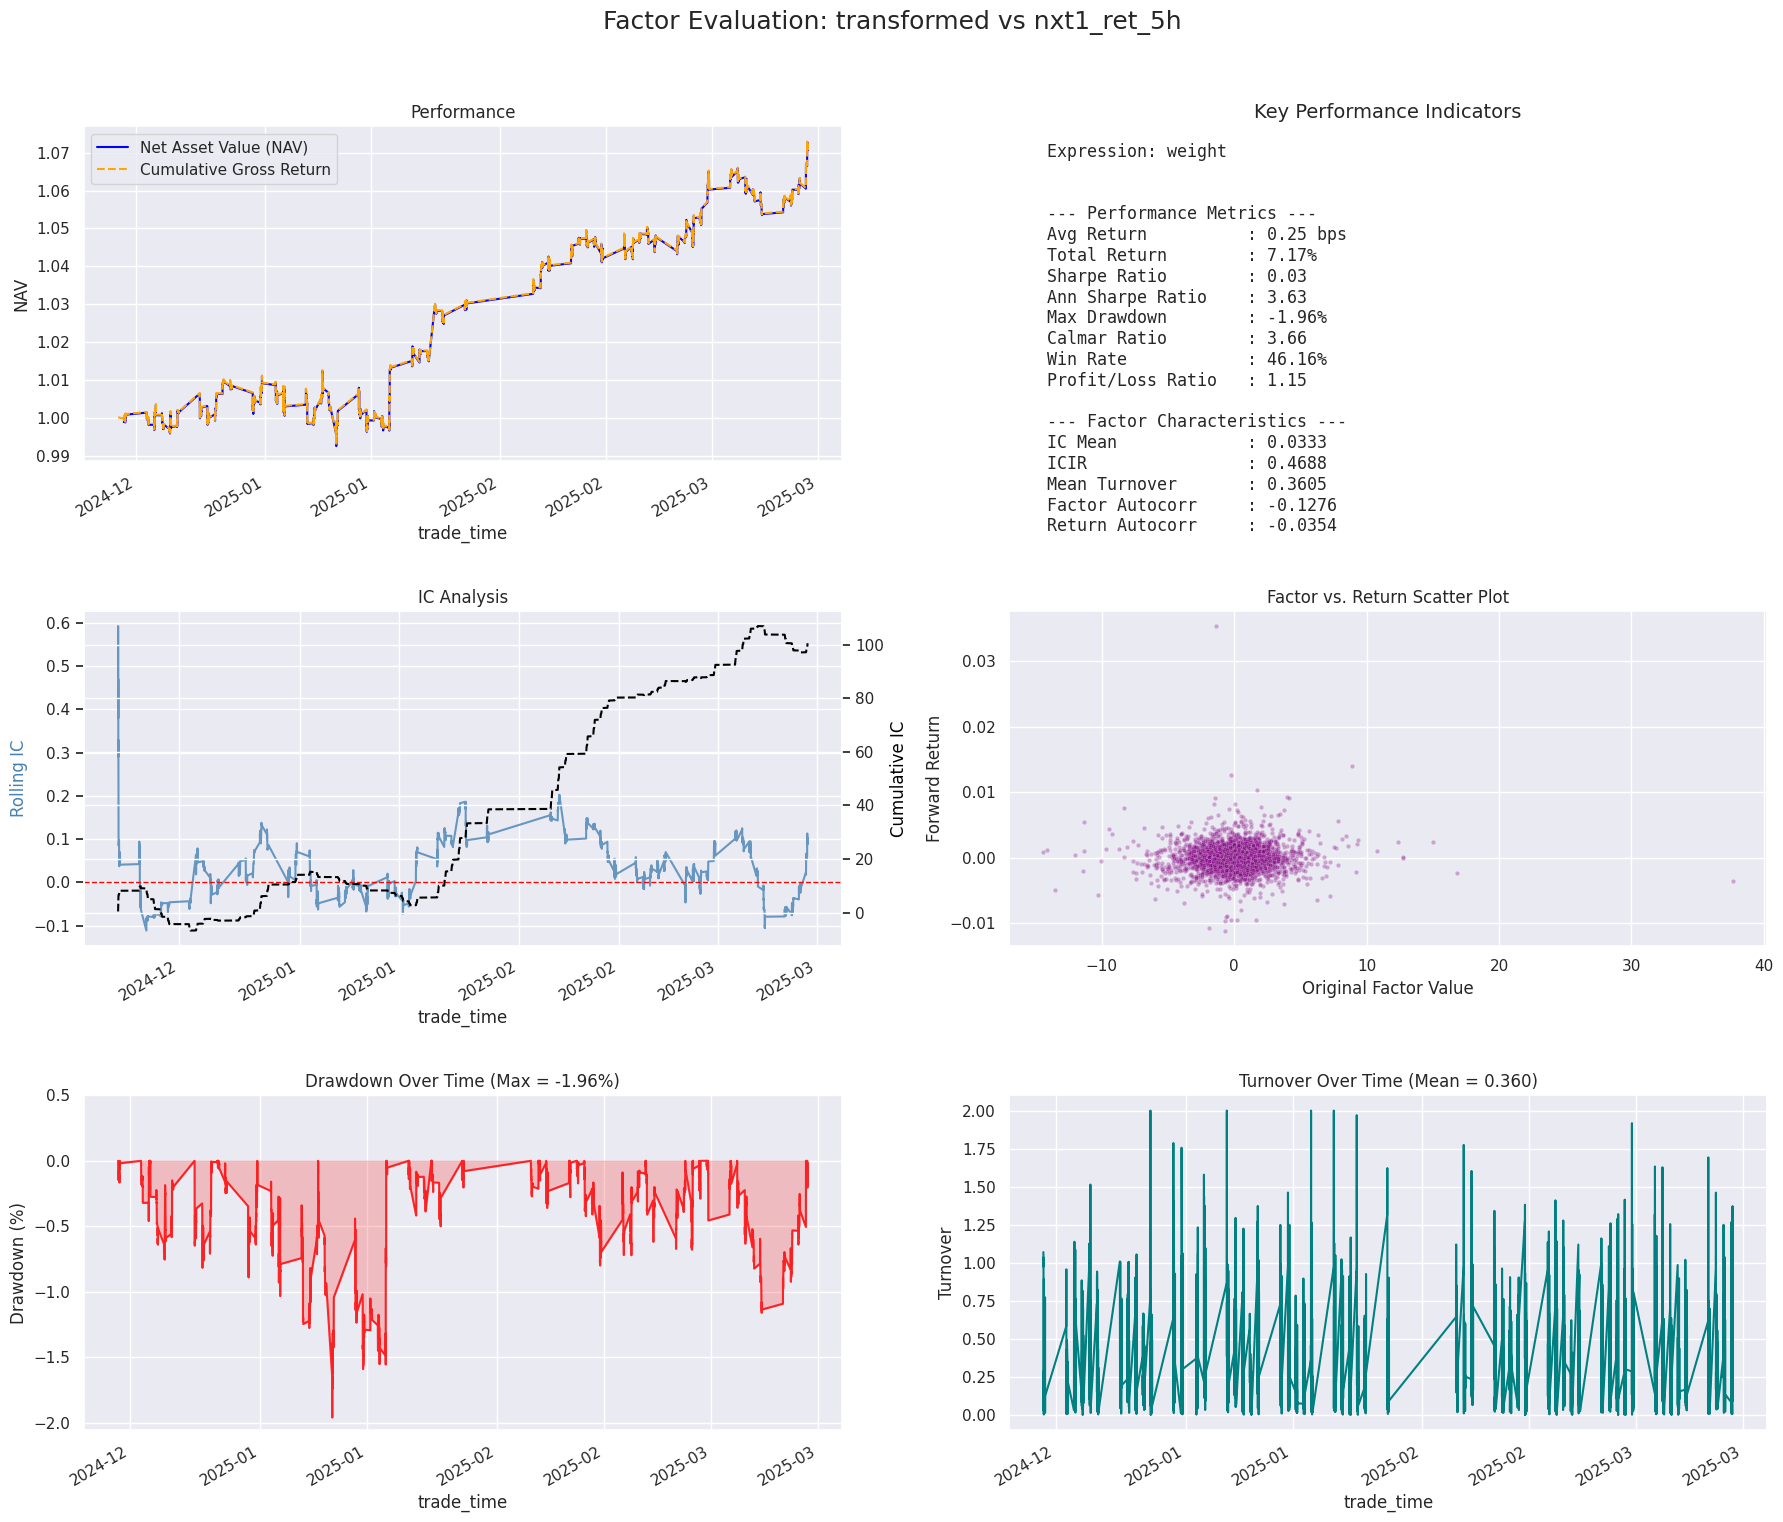

In [21]:
evaluate1.plot_results()